In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from cobaya.run import run
from collections import OrderedDict as odict

In [4]:
##Run COBAYA:
info = {"output": "chains/gaussian",
    "likelihood": {
        "gaussian": {
            "mean": [0.2, 0],
            "cov": [[0.1, 0.05],
                    [0.05,0.2]]}},
    "params": odict([
        ("a", {
            "prior": {"min": -0.5, "max": 3},
            "latex": r"\alpha"}),
        ("b", {
            "prior": {"dist": "norm", "loc": 0, "scale": 1},
            "ref": 0,
            "proposal": 0.5,
            "latex": r"\beta"}),
        ("derived_a", {
            "latex": r"\alpha^\prime"}),
        ("derived_b", {
            "latex": r"\beta^\prime"})]),
    "sampler": {
        "mcmc": None}}

updated_info, products = run(info)

[output] Products to be written into folder 'chains', with prefix 'gaussian'
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (was 2).
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Initial covariance matrix.
[mcmc] Initial point:
[prior] Reference values or pdf's for some parameters were not provided. Sampling from the prior instead for those parameters.
[mcmc] 
weight  minuslogpost         a    b  derived_a  derived_b  minuslogprior  minuslogprior__0  chi2  chi2__gaussian
   1.0      2.091721  0.335502  0.0   0.428496  -0.161956            NaN               NaN   NaN             NaN
[mcmc] Dumped checkpoint info and current covmat.
[mcmc] Sampling! (NB: nothing will be printed until 40 burn-in samples have been obtained)
[mcmc] Finished burn-in phase: discarded 40 accepted steps.
[mcmc] Checkpoint: 80 samples accepted.
[mcmc] Ready to check convergen

Removed no burn in
[root] *WARNING* outlier fraction 0.118055555556 
Mean:
[0.21021425 0.01590846]
Covariace matrix:
[[0.09244237 0.03049955]
 [0.03049955 0.16064619]]


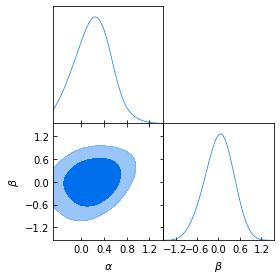

In [9]:
# Export the results to GetDist
from getdist.mcsamples import loadCobayaSamples
#print updated_info
#print products["sample"]
gd_sample = loadCobayaSamples(updated_info, products["sample"])
# Analyze and plot
import getdist.plots as gdplt
print("Mean:")
print(gd_sample.getMeans()[:2])
print("Covariace matrix:")
print(gd_sample.getCovMat().matrix[:2,:2])
# %matplotlib inline  # uncomment if running from the Jupyter notebook
import getdist.plots as gdplot
gdplot = gdplt.getSubplotPlotter()
gdplot.triangle_plot(gd_sample, ["a", "b"], filled=True)

In [2]:
# Let's repeat the results using seaborn:

#First, let read the chains and transform them into panda data frame
def read_chains(name_file):
    data_mcmc = np.genfromtxt(name_file, names=True)
    s = pd.DataFrame(data=data_mcmc, columns=data_mcmc.dtype.names)
    return s

chains_df = read_chains("chains/gaussian_1.txt")

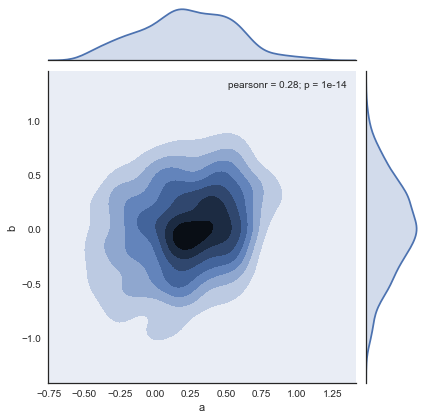

In [17]:
# Second, plot with seaborn:
sns.set(style="white")
g1 = sns.jointplot(chains_df["a"], chains_df["b"], kind="kde")
#g2 = sns.PairGrid(chains_df[['a', 'b']], diag_sharey=False)
#g2.map_lower(sns.kdeplot)
#g2.map_upper(sns.scatterplot)
#g2.map_diag(sns.kdeplot, lw=1)
#g3 = sns.pairplot(chains_df[['a', 'b']], palette="husl", 
#                  diag_kind="kde", diag_kws=dict(shade=True))

(-1.2, 1.2)

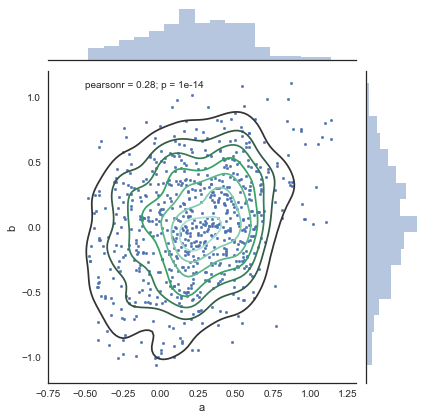

In [18]:
plt.figure(figsize=(100,60))
g = (sns.jointplot(chains_df["a"], chains_df["b"], s=7)).plot_joint(sns.kdeplot, n_levels=10, lw=1)
plt.xlim(-0.75, 1.3)
plt.ylim(-1.2, 1.2)

(2, 15)

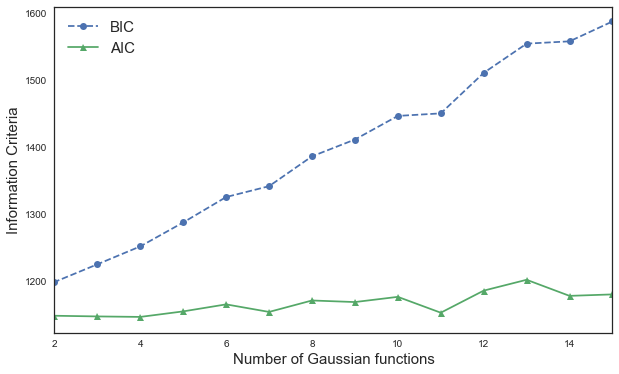

In [77]:
#Let's import sklearn mixture model as well as stacking all data to fit
from sklearn import mixture 
X = np.vstack([chains_df["a"], chains_df["b"]]).T
#X = np.vstack([chains_df["a"]]).T
number_gaussian=np.arange(1, 16, 1)
bic=[]
aic=[]
likelihood=[]
for element in number_gaussian:
    model= mixture.GaussianMixture(element)
    model.fit(X)
    bic.append(model.bic(X))
    aic.append(model.aic(X))
    likelihood.append(model._estimate_log_prob(X))
    
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(number_gaussian, bic, linestyle='dashed', marker='o', label="BIC")
ax.plot(number_gaussian, aic,linestyle='solid', marker='^',  label="AIC")
ax.set_xlabel("Number of Gaussian functions", fontsize=15)
ax.set_ylabel("Information Criteria", fontsize=15)
#ax.set_yscale("log")
#ax.set_xscale("log")
ax.legend(fontsize=15)
ax.set_xlim(2, 15)
#Detailed to zoom up!
#ax.set_ylim(-56000, -53000)

ValueError: Expected the input data X have 2 features, but got 1 features

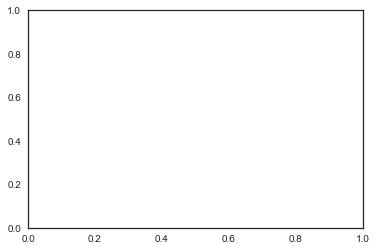

In [78]:
#Let's choose 6 as the number of gaussian functions and create the model
model_mix = mixture.GaussianMixture(1)
model_mix.fit(X)

#Fit the GMM with random data from the correspondent gaussians

fig = plt.figure()
ax = fig.add_subplot(111)
x = np.linspace(-1, 1.5, 2000).reshape(2000,1)
#
logprob = model_mix.score_samples(x)
sim_stars = model_mix.sample(100000) #careful, the information is saved in the first component
#
pdf = np.exp(logprob)
ax.plot(x, pdf, '-k')
ax.hist(sim_stars[0][:,0], normed=True, histtype='stepfilled', alpha=0.4)
plt.show()

#sim_stars = model_mix.sample(100000) #careful, the information is saved in the first component
#fig, ax = plt.subplots(1,2)
#fig.figsize=(500, 500)
#ax[0].set_ylabel('Frequency', fontsize=15)
#ax[0].hist(Color.colorYJ, normed=True, histtype='stepfilled', alpha=0.4, label = "Original")
#ax[0].hist(sim_stars[0][:,0], normed=True, histtype='stepfilled', alpha=0.4, label = "Simulated")
#ax[0].set_xlabel('a', fontsize=15)
#ax[0].set_xlim(xlim)
#ax[0].set_yscale("log")

#ax[1].hist(Color.colorJH, histtype='stepfilled', alpha=0.4, label = "Original")
#ax[1].hist(sim_stars[0][:,1], histtype='stepfilled', alpha=0.4, label = "Simulated")
#ax[1].set_xlabel('b', fontsize=15)
#ax[1].set_yticklabels([])
#ax[1].set_xlim(xlim)
#ax[1].set_yscale("log")
#ax[1].legend(bbox_to_anchor=(1., 1.0), fontsize=15)

